# Task 4 

Task 4 is about collaborations among members of parliament. Given the set of data about the 115th US congress, the goal is to find the most important person in this congress. Because the term importance can be understood in various ways, a precise definition of the concept is devised below. 

In [1]:
# import relevant packages
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd

First, the provided files are loaded into the Jupyter Notebook environment. The files "bills-115.csv" and "edgelists-115.csv" are not used, since all needed features for the analysis can be extracted from the remaining files. To get a quick overview of the data, the pandas info() method is used. From the output below, it can be concluded that there are no missing values in the relevant columns for the 452 congress members. In line with that, the adjacency matrix  has the correct number of dimensions. No apparent problems can be identified in the data.

In [2]:
# specify file paths and read in data sets as dataframes
adjacency_matrix_path = "./task4_data/adjacency_matrices-115.csv"
members_file_path = "./task4_data/members-115.csv"
individuals_file_path = "./task4_data/individuals.csv"
members_df = pd.read_csv(members_file_path, sep="\t")
individuals_df = pd.read_csv(individuals_file_path, sep="\t")

# read in adjacency matrix with pandas
adjacency_matrix = pd.read_csv(adjacency_matrix_path, sep="\t", index_col=0)
adjacency_matrix.columns = adjacency_matrix.columns.map(int)

In [3]:
# inspect completeness of data
print("Shape of adjacency matrix:", adjacency_matrix.shape, "\n")
print(members_df.info())

Shape of adjacency matrix: (452, 452) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 452 entries, 0 to 451
Data columns (total 8 columns):
name               452 non-null object
party              452 non-null object
state              452 non-null object
SGID               452 non-null int64
thomas_id          320 non-null float64
bioguide_id        452 non-null object
congress           452 non-null int64
number_of_bills    452 non-null int64
dtypes: float64(1), int64(3), object(4)
memory usage: 28.4+ KB
None


#### Definition of importance

The importance of an object is normally related to its significance or value in relation to other objects. In graph theory, there exists a number of different centrality measures that aim at indicating the importance of nodes. Depending on the dynamics of the underlying network, different measures can lead to very different results. For example, degree centrality is one of the easiest to calculate - the sum of links incident upon a node. For the analysis at hand, importance is defined as follows:

Members of parliament are considered important when they actively exercise their legislative duties and responsibilities. This is done by either sponsoring or co-sponsoring bills that influence the legislation. Therefore, an engagement score is calculated that represents the relative contribution of a congress member. It includes the relative share of sponsored bills within the 115th congress as well as the relative share of received and given signatures for bills. The latter is computed for the last ten years in order to account for engagement in the past. As a term of congress is two years long, data about the five most recent congresses are used, ranging from the 111st to the 115th congress.
> engagement score = (share of signatures received 111-115) + (share of signatures given 111-115) + (share of bills sponsored 115)

In addition to the legislative engagement, the position of an individual in the collaboration network is considered important. A member of parliament is only as powerful as the influence she has over other members that potentially can support her legislative efforts. In this context, the Eigenvector centrality measure is used to assess how well connected an individual is to other high-profile individuals in the network. Hence, it is not only the number of connections (degree centrality) that is relevant, but also the fact that connections to highly connected nodes contribute more to the score than equal connections to less connected nodes. In research, Eigenvector centrality is often used to identify opinion leaders or public figures. Besides, the Pagerank algorithm from task 3 is closely related to Eigenvector centrality.

In short, the most important person in the 115th congress is selected by determining the person who ranks best in both engagement score (exertion of legislative duties) and Eigenvector centrality (significant position in collaboration network).


#### Calculating engagement scores

In [4]:
# compute share of sponsored bills during 115th congress
members_df["share_of_bills"] = members_df["number_of_bills"] / members_df["number_of_bills"].sum()

# compute share of received/given signatures for members of the 115th congress over the past ten years (111st - 115th)
individuals_df = individuals_df[individuals_df["115"] == True]
column_list = [str(i) + "_signatures_given" for i in range(111, (115 + 1))]
individuals_df["share_of_signatures_given_111_115"]= individuals_df[column_list].sum(axis=1)
individuals_df["share_of_signatures_given_111_115"]= individuals_df["share_of_signatures_given_111_115"]/individuals_df["share_of_signatures_given_111_115"].sum()
column_list = [str(i) + "_signatures_received" for i in range(111, (115 + 1))]
individuals_df["share_of_signatures_received_111_115"]= individuals_df[column_list].sum(axis=1)
individuals_df["share_of_signatures_received_111_115"]= individuals_df["share_of_signatures_received_111_115"]/individuals_df["share_of_signatures_received_111_115"].sum()

# join both dataframes via SGID as key
individuals_df_cut = individuals_df[["SGID", "share_of_signatures_received_111_115", "share_of_signatures_given_111_115"]]
members_df = members_df.merge(individuals_df_cut, on="SGID", how='left')

# calculate engagement scores
column_list = ["share_of_signatures_received_111_115", "share_of_signatures_given_111_115", "share_of_bills"]
members_df["engagement_score"] = members_df[column_list].sum(axis=1)


#### Calculating Eigenvector centrality

In [5]:
# change all edge weights to 1 (weights are not needed for the decided approach)
adjacency_matrix.columns = adjacency_matrix.columns.map(int)
adjacency_matrix = adjacency_matrix.applymap(lambda x : 1 if (x > 0) else 0)

# create undirected graph of the collaboration network by using the adjacency matrix
collab_network = nx.from_pandas_adjacency(adjacency_matrix, create_using=nx.Graph)
centrality = nx.eigenvector_centrality(collab_network)
node_centrality_list = [(node, centrality[node]) for node in centrality]

# add centrality values to main dataframe
for node in centrality:
    members_df.loc[members_df["SGID"] == node, "eigenvector_centrality"] = centrality[node]
    
# store dataframe as CSV file
members_df.to_csv("./task4_data/member_importance.csv", encoding="utf-8")

#### Conclusion
In the last step, the two calculated importance metrics are both analyzed to find the most important congress member. Below, the top ten members are listed with regard to engagement scores and Eigenvector centrality. Looking at the top ten lists, it can be noted that the overlap is not very large, which is a good thing because engagement score and Eigenvector centrality are intended to measure different aspects of importance, though the overlap increases when looking at the top 20 or top 30 lists (legislative activity and personal network are still correlated). As a matter of fact, the member Ileana Ros-Lehtinen is present in both lists, wherefore she is chosen as the most important member of the 115th congress. Her node (SGID = 989) is highlighted in the visualized collaboration network below. It is located near the center of the network, where the connections (edges) which represent collaborative actions, are very dense. From her position, she can reach a plethora of other significant nodes. In comparison to the other members, Ileana Ros-Lehtinen stands out due to both her high legislative engagement and her strong political network.

A short excerpt of her Wikipedia article provides evidence of her important role in politics:
>Ileana Ros-Lehtinen (/ˌɪliˈɑːnə ˈrɒs ˈleɪtənən/; born Ileana Carmen Ros y Adato, July 15, 1952) is a politician and lobbyist from Miami, Florida who represented Florida's 27th congressional district from 1989 to 2019. By the end of her tenure, she **was the most senior U.S. Representative from Florida**. She **was Chairwoman of the House Foreign Affairs Committee from 2011–2013**. In 1989, Ros-Lehtinen won a special election and **became the first Cuban American and Latina elected to Congress**. She **was also the first Republican woman elected to the House from Florida**. Ros-Lehtinen **gave the first Republican response to the State of the Union address in Spanish in 2011**, and gave the third in 2014.[1]
In September 2011, Ros-Lehtinen **became the first Republican member of the U.S. Congress to co-sponsor the Respect for Marriage Act**, which would repeal the Defense of Marriage Act.[2] In July 2012, Ros-Lehtinen **became the first Republican in the House to support same-sex marriage**.[3] 

In [6]:
# create view of top ten members for both importance metrics
column_list = ["name", "SGID", "party", "engagement_score"]
df_view_1 = members_df.sort_values(by="engagement_score", ascending=False).head(10).reset_index()[column_list]
column_list = ["name", "SGID", "party", "eigenvector_centrality"]
df_view_2 = members_df.sort_values(by="eigenvector_centrality", ascending=False).head(10).reset_index()[column_list]

pd.concat([df_view_1, df_view_2], keys=["Top ten members by engagement score", "Top ten members by Eigenvector centrality"], axis=1)

Top ten members by engagement score                                     \
                                 name  SGID       party engagement_score   
0                        Lee, Barbara  1319    Democrat         0.026477   
1                 Maloney, Carolyn B.   733    Democrat         0.024794   
2                    DeLauro, Rosa L.   284    Democrat         0.023725   
3                Ros-Lehtinen, Ileana   989  Republican         0.021767   
4                    Cartwright, Matt  1846    Democrat         0.020027   
5                 Cicilline, David N.  1758    Democrat         0.019249   
6                   Grijalva, Raul M.  1459    Democrat         0.019096   
7                            Poe, Ted  1541  Republican         0.018925   
8                  Hastings, Alcee L.   515    Democrat         0.018490   
9               Smith, Christopher H.  1078  Republican         0.018314   

  Top ten members by Eigenvector centrality                    \
                                       name  SGID       party   
0                          Royce, Edward R.  1002  Republican   
1                             Paulsen, Erik  1646  Republican   
2                        McCaul, Michael T.  1543  Republican   
3                               Kelly, Mike  1754  Republican   
4                        Reichert, David G.  1549  Republican   
5                         Lynch, Stephen F.  1449    Democrat   
6                              Yoho, Ted S.  1805  Republican   
7                          Walz, Timothy J.  1583    Democrat   
8                      Ros-Lehtinen, Ileana   989  Republican   
9                            Guthrie, Brett  1638  Republican   

                          
  eigenvector_centrality  
0               0.076544  
1               0.075099  
2               0.075065  
3               0.075013  
4               0.074782  
5               0.074304  
6               0.073794  
7               0.073643  
8               0.071844  
9               0.071101

#### Visualization of collaboration network

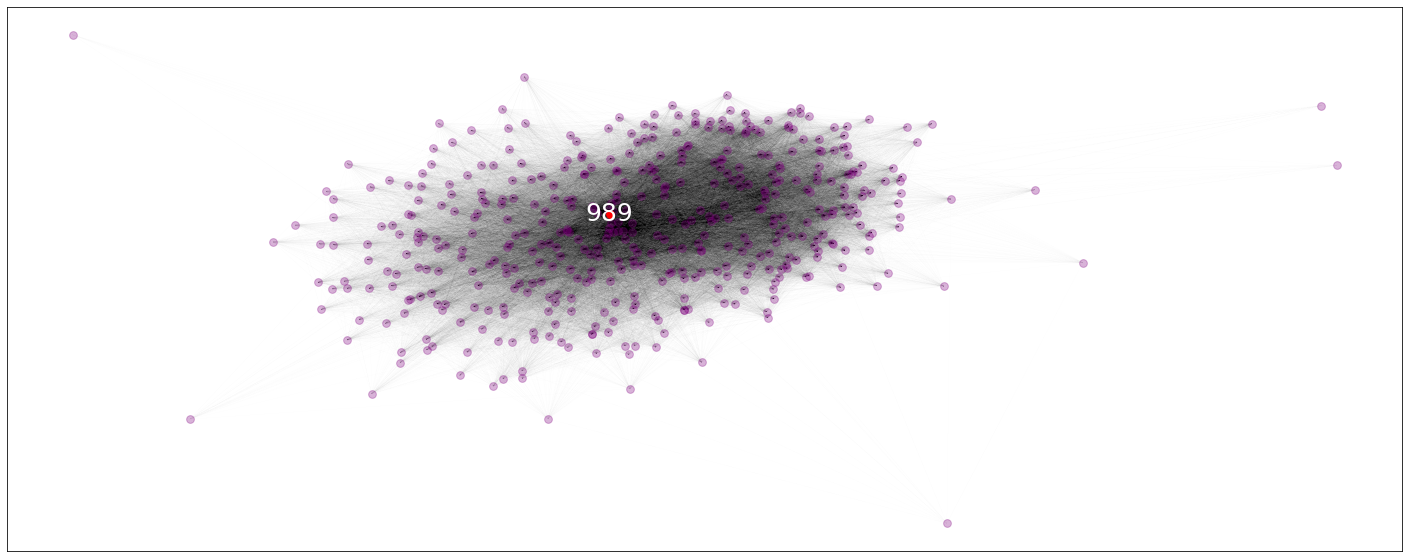

In [7]:
# display collaboration network and highlight node 989 in subplot
plt.figure(figsize = [25, 10])
collab_network.remove_nodes_from([70, 2005, 1929, 1938])
pos = nx.spring_layout(collab_network)
nx.draw_networkx(collab_network, node_size=60, pos=pos, edge_color="black", node_color="purple", width=0.015, alpha= 0.3, with_labels=0)
nx.draw_networkx(collab_network.subgraph(989), node_size=60, pos=pos, font_size=25, node_color="red", font_color="white", width=0.5, alpha= 1)